# Spam detektáló - MLOps vizsgamunka - Fehér Péter - V2

##Dataset:
https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

##1. Előkészítés

Első lépésként szükséges python-csomagok importálása.

In [53]:
import os
import json
import pickle
import logging
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

##Logging beállítása

In [54]:
LOG_DIR = "logs"
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR, exist_ok=True)

log_filepath = os.path.join(LOG_DIR, "notebook_training.log")

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(log_filepath, mode='a', encoding='utf-8'),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

## Függvények definiálása

Adat validáció függvény

In [55]:
def validate_data(df):
    logger.info("Adat validáció indítása...")
    if df.isnull().any().any():
        raise ValueError("Hiányzó értékek találhatók az adatban!")
    if len(df) < 1000:
        raise ValueError(f"Az adathalmaz túl kicsi: {len(df)} sor")
    spam_ratio = (df['label'] == 'spam').mean()
    if not (0.05 < spam_ratio < 0.5):
        logger.warning(f"Szokatlan spam arány: {spam_ratio:.3f}")
    logger.info(f"Validáció sikeres. Adatméret: {len(df)}, Spam arány: {spam_ratio:.3f}")
    return True

Metrikák mentése függvény

In [57]:
def save_metrics(metrics, filepath='artifacts/training_metrics.json'):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    metrics['timestamp'] = datetime.now().isoformat()
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(metrics, f, indent=2, ensure_ascii=False)
    logger.info(f"Metrikák elmentve: {filepath}")

Vektorizálók összehasonlítása függvény

In [58]:
def compare_vectorizers(X_train, X_test, y_train, y_test):
    logger.info("Vektorizálók összehasonlítása...")

    vectorizers = {
        'CountVectorizer': CountVectorizer(lowercase=True, stop_words='english', max_features=10000),
        'TfidfVectorizer': TfidfVectorizer(lowercase=True, stop_words='english', max_features=10000)
    }
    vectorizer_results = {}

    for name, vec in vectorizers.items():
        logger.info(f"-> Tesztelés: {name}")
        X_train_vec = vec.fit_transform(X_train)
        X_test_vec = vec.transform(X_test)
        clf = MultinomialNB()
        clf.fit(X_train_vec, y_train)
        y_pred = clf.predict(X_test_vec)
        accuracy = accuracy_score(y_test, y_pred)
        vectorizer_results[name] = {
            'accuracy': accuracy,
            'vectorizer': vec
        }
        logger.info(f"    - {name} accuracy: {accuracy:.4f}")

    best_name = max(vectorizer_results, key=lambda nm: vectorizer_results[nm]['accuracy'])
    best_vectorizer = vectorizer_results[best_name]['vectorizer']
    logger.info(f"Legjobb vektorizáló: {best_name} (accuracy={vectorizer_results[best_name]['accuracy']:.4f})")
    return best_vectorizer, vectorizer_results

Modellek összehasonlítása függvény

* Multinomial
* Logisticregression
* Randomforest
* SVC

In [59]:
def compare_models_with_hyperparameter_tuning(X_train_vec, X_test_vec, y_train, y_test):
    logger.info("Modellek összehasonlítása hiperparaméter-optimalizálással...")

    models_config = {
        'MultinomialNB': {
            'model': MultinomialNB(),
            'params': {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
        },
        'LogisticRegression': {
            'model': LogisticRegression(random_state=42, max_iter=1000),
            'params': {'C': [0.1, 1.0, 10.0, 100.0], 'solver': ['liblinear', 'lbfgs']}
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42, n_jobs=-1),
            'params': {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
        },
        'SVM': {
            'model': SVC(random_state=42, probability=True),
            'params': {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
        }
    }

    model_results = {}

    for name, cfg in models_config.items():
        logger.info(f" Hiperparaméter-optimalizálás: {name}")
        try:
            gs = GridSearchCV(
                estimator=cfg['model'],
                param_grid=cfg['params'],
                cv=5,
                scoring='accuracy',
                n_jobs=-1,
                verbose=0
            )
            gs.fit(X_train_vec, y_train)
            best_clf = gs.best_estimator_
            y_pred = best_clf.predict(X_test_vec)
            y_proba = best_clf.predict_proba(X_test_vec)

            accuracy = accuracy_score(y_test, y_pred)
            auc_sc = roc_auc_score(y_test, y_proba[:, 1])
            cv_scores = cross_val_score(best_clf, X_train_vec, y_train, cv=5, scoring='accuracy')

            model_results[name] = {
                'model': best_clf,
                'best_params': gs.best_params_,
                'accuracy': accuracy,
                'auc_score': auc_sc,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'y_pred': y_pred,
                'y_pred_proba': y_proba
            }

            logger.info(
                f"- {name}: accuracy={accuracy:.4f}, AUC={auc_sc:.4f}, CV={cv_scores.mean():.4f}±{cv_scores.std():.4f}"
            )
            logger.info(f"Legjobb paraméterek: {gs.best_params_}")
        except Exception as e:
            logger.error(f"Hiba a {name} modellnél: {e}")
            continue

    return model_results

## 2. Adat betöltése és előfeldolgozás

File létezésének ellenőrzése, adatok beolvasása , adat validálás , EDA , train-test split.

2025-06-05 08:34:56,204 - INFO - Adat betöltve: 5572 sor
2025-06-05 08:34:56,205 - INFO - Adat validáció indítása...
2025-06-05 08:34:56,212 - INFO - Validáció sikeres. Adatméret: 5572, Spam arány: 0.134


Címke-eloszlás az egész adathalmazban:
label
ham     4825
spam     747


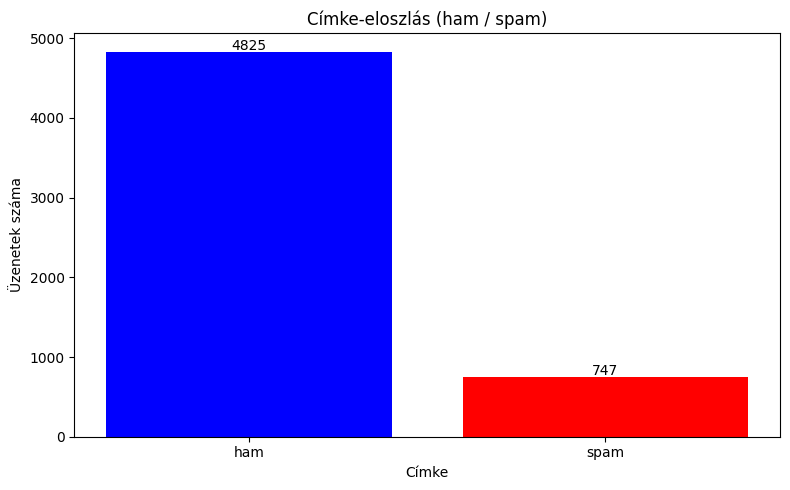


Train méret: 4457 sor, Test méret: 1115 sor


In [60]:
data_path = os.path.join('data', 'spam.csv')
if not os.path.exists(data_path):
    raise FileNotFoundError(
        f"Nem található a dataset: {data_path}. "
        "Töltsd le a 'SMS Spam Collection Dataset'-et, és helyezd a 'data/spam.csv' útvonalra."
    )

df = pd.read_csv(data_path, encoding='latin-1', usecols=['v1', 'v2'])
df.columns = ['label', 'text']
logger.info(f"Adat betöltve: {len(df)} sor")

validate_data(df)

label_counts = df['label'].value_counts()
print("Címke-eloszlás az egész adathalmazban:")
print(label_counts.to_string())

plt.bar(label_counts.index, label_counts.values, color=['blue','red'])
plt.title('Címke-eloszlás (ham / spam)')
plt.xlabel('Címke')
plt.ylabel('Üzenetek száma')
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 30, str(v), ha='center')
plt.tight_layout()
plt.show()

df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
X = df['text']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f"\nTrain méret: {X_train.shape[0]} sor, Test méret: {X_test.shape[0]} sor")


## 3. Vektorizálók összehasonlítása

- Meghívjuk a `compare_vectorizers` függvényt, amely visszaadja a legjobb vektorizálót és a részletes eredményeket.  
- A kapott `best_vectorizer`-rel előállítjuk a vektorizált mátrixokat (train és test).


In [61]:
best_vectorizer, vectorizer_results = compare_vectorizers(X_train, X_test, y_train, y_test)

X_train_vec = best_vectorizer.fit_transform(X_train)
X_test_vec = best_vectorizer.transform(X_test)

print(f"\nLegjobb vektorizáló típusa: {type(best_vectorizer).__name__}")
print(f"Vocabulary méret: {len(best_vectorizer.vocabulary_)}")
print(f"Feature matrix alakja (train): {X_train_vec.shape}")


2025-06-05 08:35:00,180 - INFO - Vektorizálók összehasonlítása...
2025-06-05 08:35:00,182 - INFO - -> Tesztelés: CountVectorizer
2025-06-05 08:35:00,284 - INFO -     - CountVectorizer accuracy: 0.9839
2025-06-05 08:35:00,285 - INFO - -> Tesztelés: TfidfVectorizer
2025-06-05 08:35:00,383 - INFO -     - TfidfVectorizer accuracy: 0.9686
2025-06-05 08:35:00,384 - INFO - Legjobb vektorizáló: CountVectorizer (accuracy=0.9839)



Legjobb vektorizáló típusa: CountVectorizer
Vocabulary méret: 7440
Feature matrix alakja (train): (4457, 7440)


## 4. Modellek hiperparaméter-optimalizálása és összehasonlítása

- Meghívjuk a `compare_models_with_hyperparameter_tuning` függvényt.  
- A függvény visszaadja az egyes modellekre vonatkozó:
  - Legjobb modell (`best_estimator_`)
  - Legjobb hiperparaméterek
  - Accuracy, AUC, CV-átlag és cv-szórás
  - Tesztelés közbeni predikciók és valószínűségek  
- Ezután kiválasztja a legjobb modellt accuracy alapján, és részletesen kiírja az eredményeket.


In [62]:
model_results = compare_models_with_hyperparameter_tuning(X_train_vec, X_test_vec, y_train, y_test)

if not model_results:
    raise RuntimeError("Egyik modell sem futott sikeresen!")
best_model_name = max(model_results, key=lambda nm: model_results[nm]['accuracy'])
best_info = model_results[best_model_name]
best_model = best_info['model']

logger.info(f"LEGJOBB MODELL: {best_model_name}")
logger.info(f"-> Accuracy: {best_info['accuracy']:.4f}")
logger.info(f"-> AUC-ROC: {best_info['auc_score']:.4f}")
logger.info(f"-> CV: {best_info['cv_mean']:.4f} ± {best_info['cv_std']:.4f}")


y_pred_best = best_info['y_pred']
y_proba_best = best_info['y_pred_proba']

print("\n" + "="*50)
print("VÉGSŐ EREDMÉNYEK")
print("="*50)
print(f"Legjobb modell: {best_model_name}")
print(f"Legjobb paraméterek: {best_info['best_params']}")
print(f"Accuracy: {best_info['accuracy']:.4f}")
print(f"AUC-ROC:  {best_info['auc_score']:.4f}")
print(f"Cross-validation: {best_info['cv_mean']:.4f} ± {best_info['cv_std']:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=['ham','spam']))
conf_mat = confusion_matrix(y_test, y_pred_best)
print(f"Confusion Matrix:\n[[TN: {conf_mat[0,0]}, FP: {conf_mat[0,1]}],\n [FN: {conf_mat[1,0]}, TP: {conf_mat[1,1]}]]")


2025-06-05 08:35:05,490 - INFO - Modellek összehasonlítása hiperparaméter-optimalizálással...
2025-06-05 08:35:05,492 - INFO -  Hiperparaméter-optimalizálás: MultinomialNB
2025-06-05 08:35:07,975 - INFO - - MultinomialNB: accuracy=0.9794, AUC=0.9827, CV=0.9838±0.0037
2025-06-05 08:35:07,976 - INFO - Legjobb paraméterek: {'alpha': 5.0}
2025-06-05 08:35:07,977 - INFO -  Hiperparaméter-optimalizálás: LogisticRegression
2025-06-05 08:35:08,929 - INFO - - LogisticRegression: accuracy=0.9848, AUC=0.9831, CV=0.9854±0.0024
2025-06-05 08:35:08,931 - INFO - Legjobb paraméterek: {'C': 100.0, 'solver': 'lbfgs'}
2025-06-05 08:35:08,932 - INFO -  Hiperparaméter-optimalizálás: RandomForest
2025-06-05 08:38:18,926 - INFO - - RandomForest: accuracy=0.9749, AUC=0.9833, CV=0.9789±0.0033
2025-06-05 08:38:18,927 - INFO - Legjobb paraméterek: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
2025-06-05 08:38:18,929 - INFO -  Hiperparaméter-optimalizálás: SVM
2025-06-05 08:40:20,280 - INFO - -


VÉGSŐ EREDMÉNYEK
Legjobb modell: LogisticRegression
Legjobb paraméterek: {'C': 100.0, 'solver': 'lbfgs'}
Accuracy: 0.9848
AUC-ROC:  0.9831
Cross-validation: 0.9854 ± 0.0024

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.97      1115
weighted avg       0.99      0.98      0.98      1115

Confusion Matrix:
[[TN: 966, FP: 0],
 [FN: 17, TP: 132]]


## 5. Eredmények vizualizálása

1. **Confusion Matrix ábrázolása**  
2. **ROC-görbe megjelenítése**  


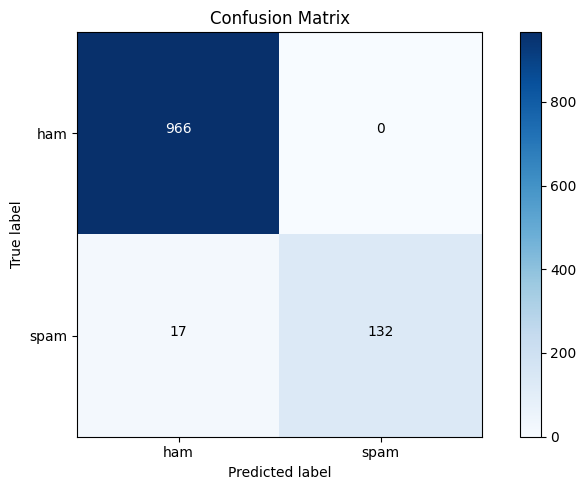

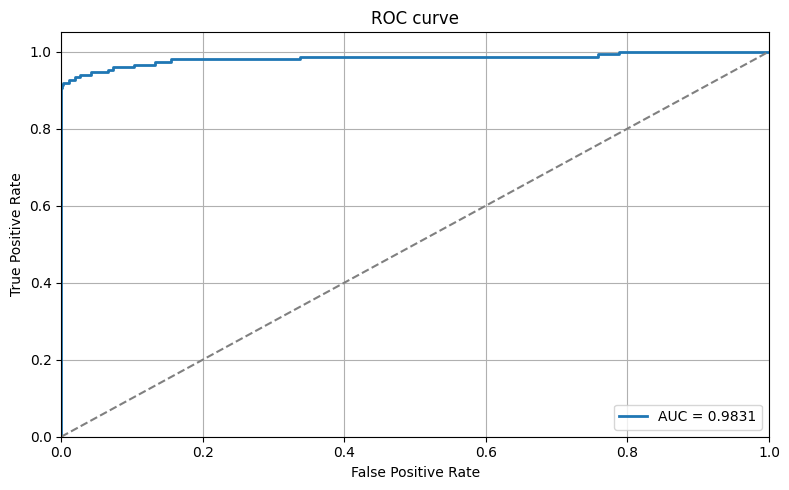

In [63]:
cm = conf_mat
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['ham', 'spam'])
plt.yticks(tick_marks, ['ham', 'spam'])
thresh = cm.max() / 2

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, str(cm[i,j]),
            ha='center',
            color='white' if cm[i,j] > thresh else 'black'
        )

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_proba_best[:, 1])
auc_score = best_info['auc_score']

plt.plot(fpr, tpr, lw=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Extra tesztesetek kipróbálása

- Néhány statikus üzenetet vektorizálok és előrejelzést készítek rájuk.  
- Predikciót confidence értékek kiiratása.


In [64]:
test_messages = [
    "Congrats! You've won a $1000 Walmart gift card. Go to http://you.won.com to claim now.",
    "Hey, are we still on for dinner tonight?",
    "Free entry in 2 a weekly competition to win FA Cup final tickets. Text FA to 845. They cost 50p.",
    "Don't forget to bring your laptop tomorrow for the meeting."
]

print("EXTRA TESZTESETEK:")
for msg in test_messages:
    X_sample = best_vectorizer.transform([msg])
    pred = best_model.predict(X_sample)[0]
    proba = best_model.predict_proba(X_sample)[0]
    label = 'spam' if pred == 1 else 'ham'
    confidence = proba[pred]
    print(f"Üzenet: \"{msg}\"\n -> Predikció: {label}, confidence: {confidence:.4f}\n")


EXTRA TESZTESETEK:
Üzenet: "Congrats! You've won a $1000 Walmart gift card. Go to http://you.won.com to claim now."
 -> Predikció: spam, confidence: 1.0000

Üzenet: "Hey, are we still on for dinner tonight?"
 -> Predikció: ham, confidence: 1.0000

Üzenet: "Free entry in 2 a weekly competition to win FA Cup final tickets. Text FA to 845. They cost 50p."
 -> Predikció: spam, confidence: 0.9939

Üzenet: "Don't forget to bring your laptop tomorrow for the meeting."
 -> Predikció: ham, confidence: 1.0000



## 7. Metrikák mentése JSON-be

- Az összesített metrikákat JSON formátumban elmentjük az `artifacts/training_metrics.json` fájlba.  
- A mentett metrikák tartalmazzák az experiment információt, vektorizáló összehasonlítását, modell összehasonlítását, és a legjobb modell részletes metrikáit.


In [65]:
detailed_metrics = {
    'experiment_info': {
        'timestamp': datetime.now().isoformat(),
        'dataset_size': len(df),
        'train_size': int(X_train.shape[0]),
        'test_size': int(X_test.shape[0])
    },
    'vectorizer_comparison': {
        name: {'accuracy': float(res['accuracy'])}
        for name, res in vectorizer_results.items()
    },
    'best_vectorizer': type(best_vectorizer).__name__,
    'vocabulary_size': int(len(best_vectorizer.vocabulary_)),
    'model_comparison': {
        name: {
            'accuracy': float(res['accuracy']),
            'auc_score': float(res['auc_score']),
            'cv_mean': float(res['cv_mean']),
            'cv_std': float(res['cv_std']),
            'best_params': res['best_params']
        }
        for name, res in model_results.items()
    },
    'best_model': {
        'name': best_model_name,
        'accuracy': float(best_info['accuracy']),
        'auc_roc': float(best_info['auc_score']),
        'cv_mean': float(best_info['cv_mean']),
        'cv_std': float(best_info['cv_std']),
        'best_params': best_info['best_params'],
        'precision_spam': float(classification_report(y_test, y_pred_best, target_names=['ham','spam'], output_dict=True)['spam']['precision']),
        'recall_spam': float(classification_report(y_test, y_pred_best, target_names=['ham','spam'], output_dict=True)['spam']['recall']),
        'f1_spam': float(classification_report(y_test, y_pred_best, target_names=['ham','spam'], output_dict=True)['spam']['f1-score']),
        'confusion_matrix': conf_mat.tolist()
    },
    'model_version': f"v2.0_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
}

save_metrics(detailed_metrics, filepath='artifacts/training_metrics.json')


2025-06-05 08:41:21,174 - INFO - Metrikák elmentve: artifacts/training_metrics.json


## 8. Legjobb modell és vektorizáló mentése pickle-ben

- A `best_vectorizer` és `best_model` objektumokat egy pickle-fájlba mentjük (artifacts/spam_model.pkl).  
- A metadata mezőben szerepel a tanítás ideje, a modell neve, accuracy, AUC stb.


In [66]:
os.makedirs('artifacts', exist_ok=True)
artifact_path = os.path.join('artifacts', 'spam_model.pkl')

model_data = {
    'vectorizer': best_vectorizer,
    'model': best_model,
    'metadata': {
        'trained_at': datetime.now().isoformat(),
        'model_name': best_model_name,
        'best_params': best_info['best_params'],
        'accuracy': best_info['accuracy'],
        'auc_roc': best_info['auc_score'],
        'cv_score': best_info['cv_mean'],
        'model_version': detailed_metrics['model_version']
    }
}

with open(artifact_path, 'wb') as f:
    pickle.dump(model_data, f)

logger.info(f"Legjobb modell sikeresen mentve: {artifact_path}")


2025-06-05 08:41:25,620 - INFO - Legjobb modell sikeresen mentve: artifacts/spam_model.pkl
